## Application Diagram

<img src = "Screenshot from 2023-05-11 18-30-51.png">

In [1]:
import os
import gc
import cv2
import sys
import torch
import warnings
import collections
import transformers
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from transformers import DistilBertTokenizer, DistilBertModel, DistilBertConfig

#installing them manually as Kaggle submission does not allow getting them from internet
sys.path.append('/kaggle/input/shopee-helpers/pytorch-image-models')
import timm

!pip install "../input/faissgpuwheel/faiss_gpu-1.7.0-cp37-cp37m-manylinux2014_x86_64.whl"
import faiss

warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('seaborn-whitegrid')

Processing /kaggle/input/faissgpuwheel/faiss_gpu-1.7.0-cp37-cp37m-manylinux2014_x86_64.whl


In [2]:
#flag value to control train or test phase selection
COMPUTE_CV = True

## Load model weights for bert based models

In [3]:
model_weight_paths = ['/kaggle/input/shopee-helpers/distil_bert_pretrained_fold_0.pth', '/kaggle/input/shopee-helpers/distil_bert_pretrained_fold_1.pth']
tokenizer = DistilBertTokenizer.from_pretrained('/kaggle/input/shopee-helpers/tokenizer')

# general
loader_num_workers = 2
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')

## Initialization of different parameters as helper

In [4]:
if COMPUTE_CV:
    test = pd.read_csv('../input/shopee-product-matching/train.csv')
else:
    test = pd.read_csv('../input/shopee-product-matching/test.csv')
#test = test.drop(columns='image_phash')

LEN_TEST = len(test)

BASE = '../input/shopee-product-matching/test_images/'
if COMPUTE_CV:
    BASE = '../input/shopee-product-matching/train_images/'
    
CHUNK = 1024*4
CTS = LEN_TEST//CHUNK
if LEN_TEST%CHUNK!=0:
    CTS += 1
    
test_batch_size = 128

# image model
GEM_P = 4
image_size = 420

# text model
text_max_length = 84
seed = 42

In [5]:
test["path"] = BASE + test["image"]
img_names = test["image"].tolist()
img_ids = test["posting_id"].tolist()
phashes = test["image_phash"].tolist()

In [6]:
test.head()

,posting_id,image,image_phash,title,label_group,path
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794,../input/shopee-product-matching/train_images/...
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045,../input/shopee-product-matching/train_images/...
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891,../input/shopee-product-matching/train_images/...
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188,../input/shopee-product-matching/train_images/...
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069,../input/shopee-product-matching/train_images/...


## Pre-processing for ground truth value for calculating training f-1 score

In [7]:
if COMPUTE_CV:
    test = pd.read_csv("/kaggle/input/shopee-product-matching/train.csv")
    true_pred = []
    labels = test["label_group"].to_list()
    for val in labels:
        temp_df = test.loc[test['label_group'] == val]
        same_items = temp_df["posting_id"].to_list()
        str_items = (" ").join(same_items)
        true_pred.append(str_items)
    test["sim_items"] = true_pred

## Tokenize titles

In [8]:
texts = list(test['title'].apply(lambda o: str(o)).values)
text_encodings = tokenizer(texts, 
                           padding=True, 
                           truncation=True, 
                           max_length=text_max_length)

test['input_ids'] = text_encodings['input_ids']
test['attention_mask'] = text_encodings['attention_mask']

del texts, text_encodings, tokenizer
_=gc.collect()

## Data pre-processing and building the dataloader for models

In [9]:
class Shopee(Dataset):
    def __init__(self, df, image_dir, augs):
        self.df = df
        self.augs = augs 
        self.image_dir = image_dir


    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        item = {'input_ids': torch.tensor(self.df['input_ids'].iloc[idx]), 'attention_mask': torch.tensor(self.df['attention_mask'].iloc[idx])}
        
        # image
        image = cv2.imread(self.image_dir + self.df.loc[idx, 'image']).astype(np.uint8)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = self.augs(image=image)['image']

        return image, item
    
def make_aug(scale=1.0, horizontal_flip=False):
    im_size = int(round(scale*image_size))
    if horizontal_flip:
        valid_aug = A.Compose([A.LongestMaxSize(max_size=im_size, p=1.0),
                               A.PadIfNeeded(min_height=im_size, min_width=im_size, border_mode=0, p=1.0),
                               A.HorizontalFlip(p=1.0),
                               A.Normalize(p=1.0),
                               ToTensorV2(p=1.0)])
        
    else:
        valid_aug = A.Compose([A.LongestMaxSize(max_size=im_size, p=1.0),
                               A.PadIfNeeded(min_height=im_size, min_width=im_size, border_mode=0, p=1.0),
                               A.Normalize(p=1.0),
                               ToTensorV2(p=1.0)])
        
    return valid_aug

## NFNetF0 model

In [10]:
class AdaptiveGeneralizedMeanPool2d(nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super(AdaptiveGeneralizedMeanPool2d, self).__init__()
        self.p = p
        self.eps = eps
        self.flatten1 = nn.Flatten()

    def forward(self, x):
        return self.gem(x, p=self.p, eps=self.eps)
        
    def gem(self, x, p=3, eps=1e-6):
        x = F.adaptive_avg_pool2d(input=x.clamp(min=eps).pow(p), output_size=(1, 1)).pow(1./p)
        x = self.flatten1(x)
        return x

class NFNetF0_GeM_L2(nn.Module):
    def __init__(self, num_embeddings, pretrained=True):
        super(NFNetF0_GeM_L2, self).__init__()
        self.model = timm.create_model('dm_nfnet_f0', pretrained=pretrained)
        self.model.head.global_pool = AdaptiveGeneralizedMeanPool2d(p=GEM_P)
        #print(self.model)
        num_features = self.model.head.fc.in_features
        print(num_features)
        self.model.head.fc = nn.Linear(num_features, num_embeddings)

    def forward(self, x):
        x = self.model(x)
        x = F.normalize(x, p=2, dim=1, eps=1e-12)
        
        return x

## DistilBERT model

In [11]:
class DistilBERT_L2(nn.Module):
    def __init__(self, bert_model):
        super(DistilBERT_L2, self).__init__()
        self.bert_model = bert_model
    
    def forward(self, batch):
        output = self.bert_model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'])
        last_hidden_state = output.last_hidden_state
        CLS_token_state = last_hidden_state[:, 0, :]
        CLS_token_state = F.normalize(CLS_token_state, p=2, dim=1, eps=1e-12)
        
        return CLS_token_state
    

## Concatenate two models output

In [12]:
class JointModel(nn.Module):
    def __init__(self, text_model, image_model):
        super(JointModel, self).__init__()
        self.text_model = text_model
        self.image_model = image_model
        self.fc1 = nn.Linear(768 + 768, 768)
    
    def forward(self, image_input, batch):
        # image embeddings
        image_emb = self.image_model(image_input)

        text_emb = self.text_model(batch)
        
        x = torch.cat((image_emb, text_emb), dim=1)
        return x

In [13]:
image_model = NFNetF0_GeM_L2(768, False)
bert_config = DistilBertConfig(activation='gelu',
                               attention_dropout=0.1,
                               dim=768,
                               dropout=0.1,
                               hidden_dim=3072,
                               initializer_range=0.02,
                               max_position_embeddings=512,
                               model_type='distilbert',
                               n_heads=12,
                               n_layers=6,
                               output_hidden_states=True,
                               pad_token_id=0,
                               qa_dropout=0.1,
                               seq_classif_dropout=0.2,
                               sinusoidal_pos_embds=True,
                               tie_weights_=True,
                               vocab_size=32000)
bert_model = DistilBertModel(bert_config)
text_model = DistilBERT_L2(bert_model)

model_1 = JointModel(text_model, image_model)
_=model_1.to(device)
_=model_1.eval()

model_2 = JointModel(text_model, image_model)
_=model_2.to(device)
_=model_2.eval()
del bert_model, text_model, image_model

3072


In [14]:
def joint_embedder(df, model_1, model_2, scale=1.0, flip=False):
    embeds = []
    CHUNK = 1024*4
    for i,j in enumerate(range(CTS)):
        a = j*CHUNK
        b = (j+1)*CHUNK
        b = min(b,len(df))
        
        test_data = Shopee(df.iloc[a:b].reset_index(drop=True),
                           BASE,
                           augs=make_aug(scale=scale, horizontal_flip=flip))
        test_loader = DataLoader(test_data,
                                 shuffle=False,
                                 num_workers=loader_num_workers,
                                 pin_memory=False,# False:faster
                                 batch_size=test_batch_size)
        with torch.no_grad():
            for inputs, batch in tqdm(test_loader):
                batch = {k: v.to(device) for k, v in batch.items()}
                inputs = inputs.to(device)
                embedding_1 = model_1(inputs, batch).detach().cpu().numpy()
                embedding_2 = model_2(inputs, batch).detach().cpu().numpy()
                embeds.append(np.concatenate((embedding_1, embedding_2), axis = 1))
        
    return np.concatenate(embeds)

In [15]:
%load_ext memory_profiler


In [17]:

%memit model_1.load_state_dict(torch.load(model_weight_paths[0], map_location='cpu'))
%memit model_2.load_state_dict(torch.load(model_weight_paths[1], map_location='cpu'))

peak memory: 3371.81 MiB, increment: 345.33 MiB
peak memory: 3385.35 MiB, increment: 332.13 MiB


In [18]:
import time
st = time.time()
joint_embeddings = joint_embedder(test, model_1, model_2, flip=False)
print(time.time() - st)
joint_embeddings.shape

100%|██████████| 12/12 [01:12<00:00,  6.07s/it]


1669.7144565582275


(34250, 3072)

## Build Faiss index

In [19]:
# number nearest neighbour to calculate
topk=30

N,D = joint_embeddings.shape
cpu_index = faiss.IndexFlatL2(D)
gpu_index = faiss.index_cpu_to_all_gpus(cpu_index)
gpu_index.add(joint_embeddings)
cluster_distance,cluster_index = gpu_index.search(x=joint_embeddings, k=topk)

## Caclculate and prepare output for Kaggle submission

In [20]:
threshold = 1.5
all_id_list = []
for k, id_ in enumerate(img_ids):
    q_cluster_distance = cluster_distance[k]
    q_cluster_index = cluster_index[k]
    sim_ids = []
    for i, indx in enumerate(q_cluster_index):
        if q_cluster_distance[i] <= threshold:
            sim_ids.append(img_ids[indx])
    for p, hash_ in enumerate(phashes):
        if hash_ == phashes[k]:
            if img_ids[p] not in sim_ids:
                sim_ids.append(img_ids[p])
    str_ids = (" ").join(sim_ids)
    all_id_list.append(str_ids)

In [21]:
data = {'posting_id': img_ids, 'matches': all_id_list}
df_sub = pd.DataFrame.from_dict(data)
df_sub

,posting_id,matches
0,train_129225211,train_129225211 train_2278313361
1,train_3386243561,train_3386243561 train_3423213080 train_380550...
2,train_2288590299,train_2288590299
3,train_2406599165,train_2406599165
4,train_3369186413,train_3369186413 train_921438619
...,...,...
34245,train_4028265689,train_4028265689
34246,train_769054909,train_769054909 train_1463059254
34247,train_614977732,train_614977732 train_1264798465 train_9568348...
34248,train_3630949769,train_3630949769 train_1431563868 train_341939...


In [22]:
df_sub.to_csv("submission.csv", index = False)

## Calculate f1 score if using the training data

In [23]:
def f1_score(y_true, y_pred):
    y_true = y_true.apply(lambda x: set(x.split()))
    y_pred = y_pred.apply(lambda x: set(x.split()))
    intersection = np.array([len(x[0] & x[1]) for x in zip(y_true, y_pred)])
    len_y_pred = y_pred.apply(lambda x: len(x)).values
    len_y_true = y_true.apply(lambda x: len(x)).values
    f1 = 2 * intersection / (len_y_pred + len_y_true)
    return f1

In [24]:
if COMPUTE_CV:
    thresholds = [1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3.0]
    scores = []
    for threshold in thresholds:
        all_id_list = []
        for k, id_ in enumerate(img_ids):
            q_cluster_distance = cluster_distance[k]
            q_cluster_index = cluster_index[k]
            sim_ids = []
            for i, indx in enumerate(q_cluster_index):
                if q_cluster_distance[i] <= threshold:
                    sim_ids.append(img_ids[indx])
            for p, hash_ in enumerate(phashes):
                if hash_ == phashes[k]:
                    if img_ids[p] not in sim_ids:
                        sim_ids.append(img_ids[p])
            str_ids = (" ").join(sim_ids)
            all_id_list.append(str_ids)

        data = {'posting_id': img_ids, 'matches': all_id_list}
        df_sub = pd.DataFrame.from_dict(data)
        test["f1"] = f1_score(test["sim_items"], df_sub["matches"])
        score = test['f1'].mean()
        scores.append(score)
        print("threshold:", threshold, "f1 score:" ,score)

threshold: 1.8 f1 score: 0.7681897454894069
threshold: 1.9 f1 score: 0.7811332601101314
threshold: 2.0 f1 score: 0.79186180789142
threshold: 2.1 f1 score: 0.8019732875623379
threshold: 2.2 f1 score: 0.8112508400653371
threshold: 2.3 f1 score: 0.8192398227103681
threshold: 2.4 f1 score: 0.8259786369145641
threshold: 2.5 f1 score: 0.8317751873495196
threshold: 2.6 f1 score: 0.835609028249566
threshold: 2.7 f1 score: 0.83884836047363
threshold: 2.8 f1 score: 0.8398392526685874
threshold: 2.9 f1 score: 0.8396192834451389
threshold: 3.0 f1 score: 0.8378549750744215


In [25]:
def plot_image(img_path):
    img = cv2.imread(os.path.join(BASE, img_path))
    plt.imshow(img)
    plt.show()

## Example outputs from our models

Image id: train_2530173108  index: 1906  Similar Image id: train_2530173108  score: 2.3841858e-06


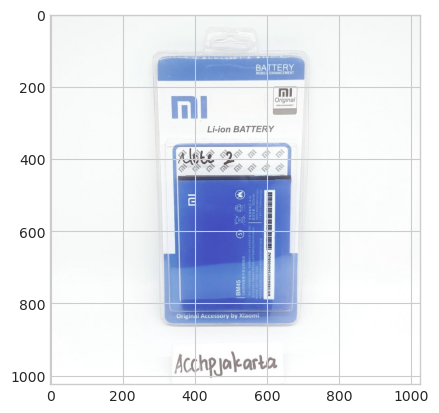

Image id: train_2530173108  index: 3295  Similar Image id: train_3134007800  score: 0.6602473


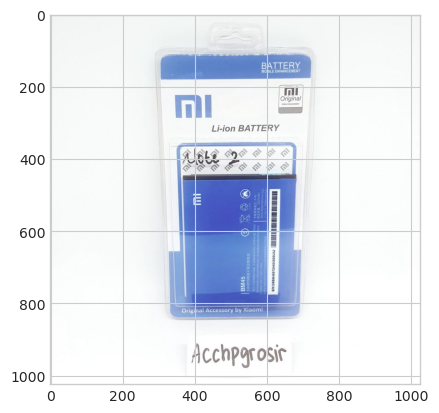

Image id: train_2530173108  index: 19506  Similar Image id: train_109678918  score: 1.7075176


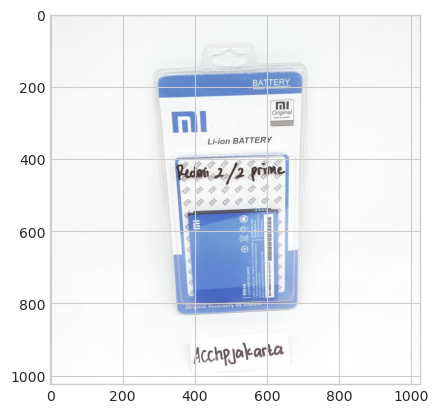

Image id: train_2530173108  index: 6322  Similar Image id: train_396394645  score: 1.9461646


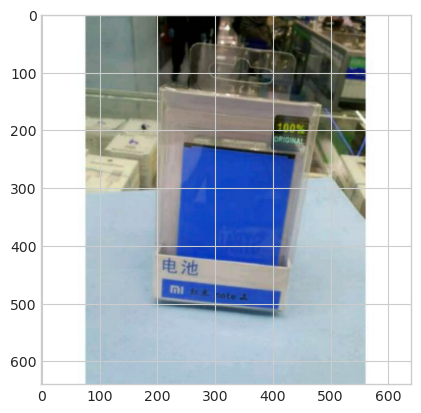

Image id: train_2530173108  index: 1734  Similar Image id: train_491708663  score: 2.2615123


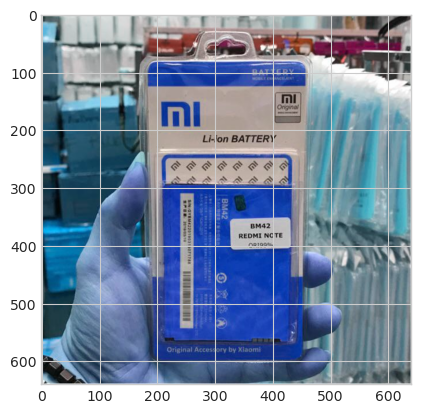

In [26]:
if COMPUTE_CV:
    query_id = 1906
    q_cluster_distance = cluster_distance[query_id]
    q_cluster_index = cluster_index[query_id]
    for i, indx in enumerate(q_cluster_index):
        if q_cluster_distance[i] <= threshold:
            print("Image id:", img_ids[query_id], " index:", indx, " Similar Image id:", img_ids[indx]," score:", q_cluster_distance[i] )
            plot_image(img_names[indx])

Image id: train_2352028503  index: 21688  Similar Image id: train_2352028503  score: 0.0


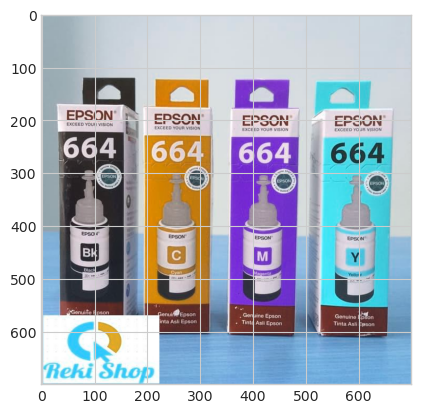

Image id: train_2352028503  index: 23549  Similar Image id: train_3392119229  score: 0.88809323


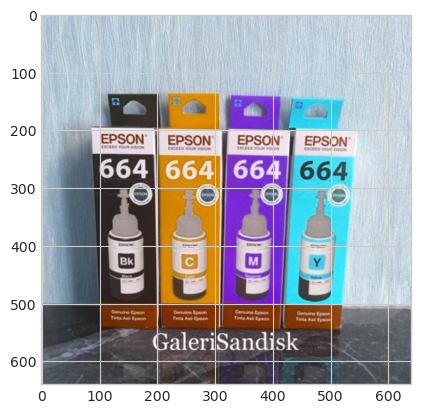

Image id: train_2352028503  index: 34215  Similar Image id: train_2079568096  score: 1.3388796


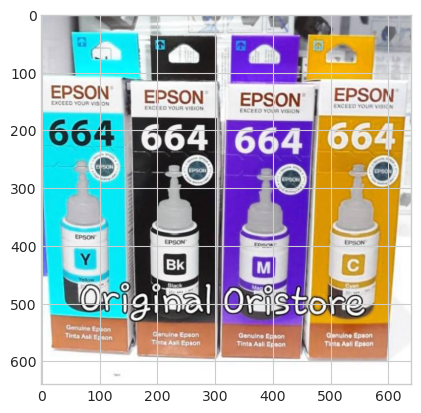

Image id: train_2352028503  index: 20688  Similar Image id: train_829584474  score: 2.0261621


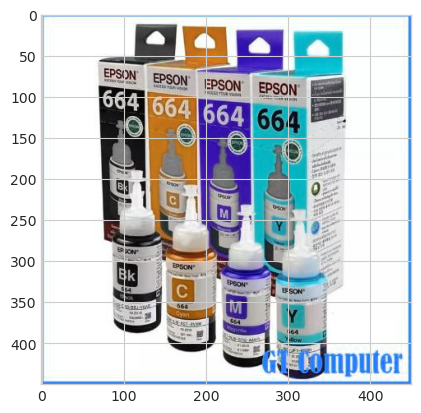

Image id: train_2352028503  index: 828  Similar Image id: train_1858724553  score: 2.96489


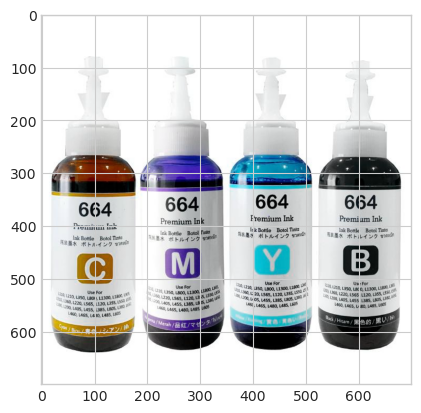

In [27]:
if COMPUTE_CV:
    query_id = 21688
    q_cluster_distance = cluster_distance[query_id]
    q_cluster_index = cluster_index[query_id]
    for i, indx in enumerate(q_cluster_index):
        if q_cluster_distance[i] <= threshold:
            print("Image id:", img_ids[query_id], " index:", indx, " Similar Image id:", img_ids[indx]," score:", q_cluster_distance[i] )
            plot_image(img_names[indx])

## Some failed case with the actual cases

Image id: train_1345163924  index: 30863  Similar Image id: train_1345163924  score: 0.0


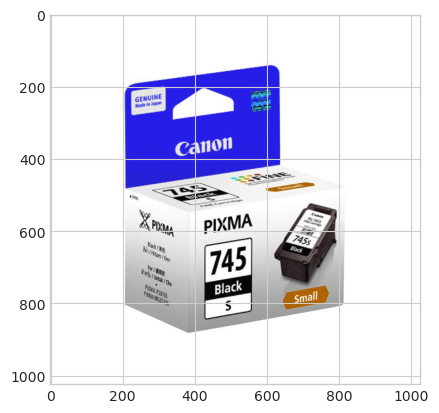

Image id: train_1345163924  index: 13516  Similar Image id: train_670411946  score: 0.5688529


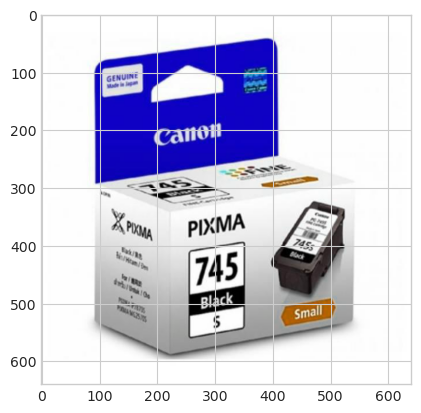

Image id: train_1345163924  index: 26219  Similar Image id: train_1520245749  score: 0.9229224


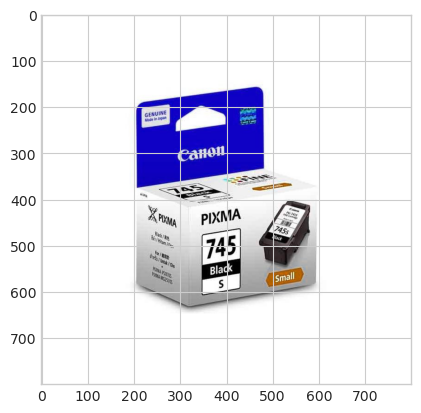

Image id: train_1345163924  index: 3333  Similar Image id: train_3971348555  score: 1.4660497


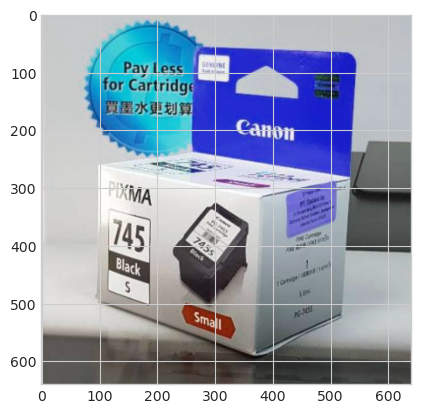

Image id: train_1345163924  index: 827  Similar Image id: train_3884157725  score: 2.3020225


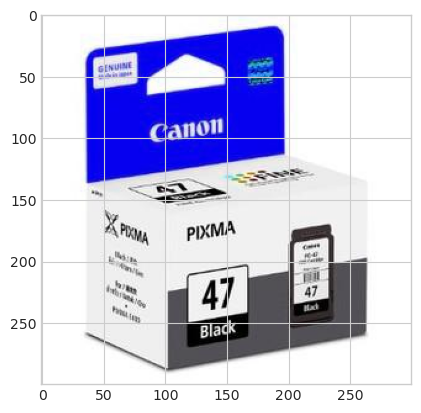

Image id: train_1345163924  index: 31424  Similar Image id: train_2502395000  score: 2.6584208


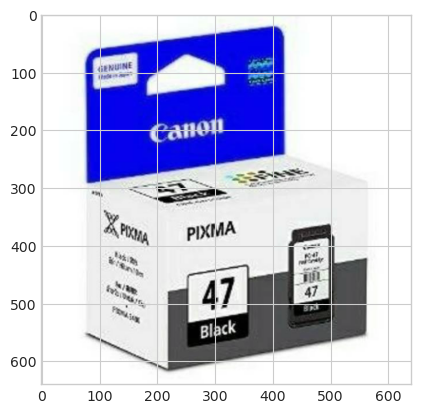

In [28]:
if COMPUTE_CV:
    query_id = 30863
    q_cluster_distance = cluster_distance[query_id]
    q_cluster_index = cluster_index[query_id]
    for i, indx in enumerate(q_cluster_index):
        if q_cluster_distance[i] <= threshold:
            print("Image id:", img_ids[query_id], " index:", indx, " Similar Image id:", img_ids[indx]," score:", q_cluster_distance[i] )
            plot_image(img_names[indx])

## Kaggle submissions

<img src = "Screenshot from 2023-05-11 23-53-25.png">

## Accuracy Metrics

## Accuracy metrics with 1536 size embeddings
<img src = "Screenshot from 2023-05-04 10-28-46.png">

## Accuracy metrics with 3072 size embeddings

<img src = "Screenshot from 2023-05-04 10-29-29.png"/>